In [43]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

In [44]:
DIR = "/Users/maggicl/Git/bachelorThesis/spatial_resource_waste/"

In [156]:
NAMES = {4: 'EVICT', 5: 'FAIL', 6: 'FINISH', 7: 'KILL'}

def plot_df(df, cluster, type_of_data):
    
    df = df[df["term"].isin(range(4,8))].sort_values("term")
    
    s = df.sum()
    #print("Cluster " + cluster + ":")
    df["cpu"] = df["cpu"] / s["cpu"]
    df["ram"] = df["ram"] / s["ram"]
    
    latex = df.copy()
    latex["Task termination"] = latex["term"].apply(lambda x: NAMES[x])
    del latex["term"]
    latex["% CPU"] = (latex["cpu"] * 100).round(2).apply(lambda x: "%2.02f" % x) + "%"
    del latex["cpu"]
    latex["% Memory"] = (latex["ram"] * 100).round(2).apply(lambda x: "%2.02f" % x) + "%"
    del latex["ram"]
    #print(latex.to_latex(index=False)) 

    df2 = df.copy()
    df["kind"] = "CPU"
    df["percent"] = df["cpu"] * 100
    del df["cpu"]
    del df["ram"]
    
    df2["kind"] = "Memory"
    df2["percent"] = df2["ram"] * 100
    del df2["cpu"]
    del df2["ram"]
    
    df = pd.concat([df, df2])
    
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 4)
    
    colors = plt.cm.Spectral([0.2, 0.4, 0.8, 0.9])
    
    a = pd.plotting.table(ax, latex.set_index("Task termination"), rowColours=colors,
                         bbox=[0,-0,1,0.3])
    ax.set_ylim(bottom=-50, top=105)
    print(a)
    
    bottom = [0, 0]
    lines = []
    for t in [4,5,6,7]:
        dft = df[df.term==t]
        line = plt.bar(x=dft["kind"], bottom=bottom, height=dft["percent"], 
                       color=colors[t-4], width=0.85)
        #ax.bar_label(line, label_type='center', fmt="%.02f%%")
        lines.append(line)
        bottom += df[df.term==t]["percent"].values
    #plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL"],
    #          bbox_to_anchor=(1,1))
    if cluster == "2011":
        plt.title("2011 data (%s resources)" % type_of_data)
    elif cluster == "all":
        plt.title("2019 data (%s resources)" % type_of_data)
    else:
        plt.title("Cluster %s (%s resources)" % (cluster.upper(), type_of_data))
    
    ax.set_xticks([])
    ax.set_yticks([0,20,40,60,80,100])
    fig.savefig('../report/figures/spatial_resource_waste/%s-%s.pgf' % 
                (type_of_data, cluster))
    plt.show()
    

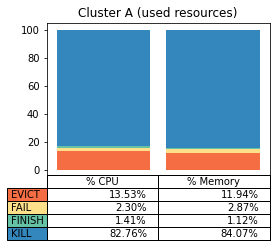

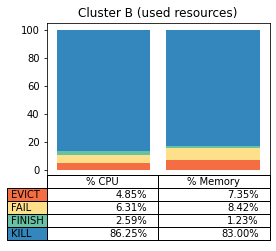

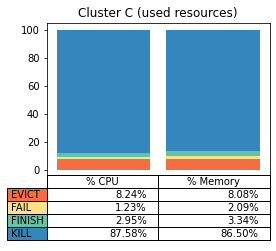

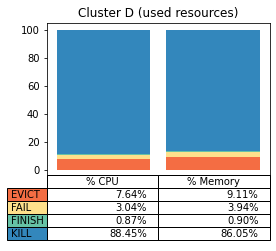

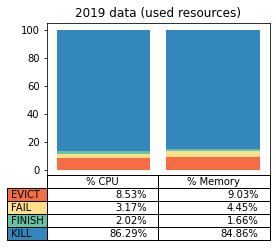

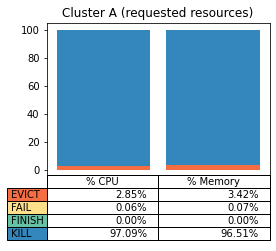

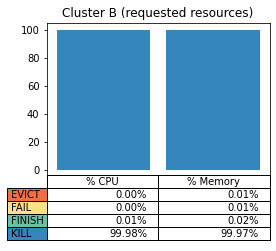

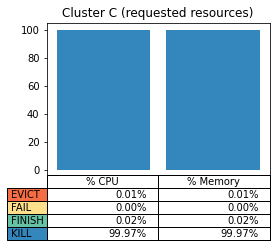

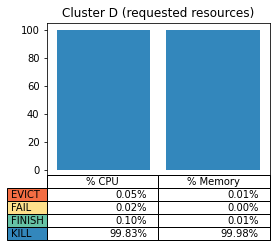

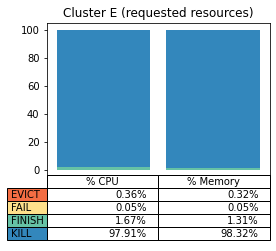

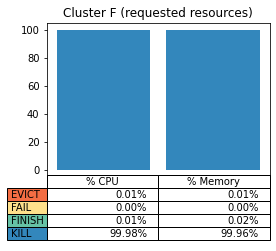

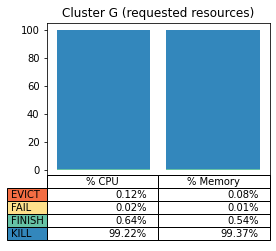

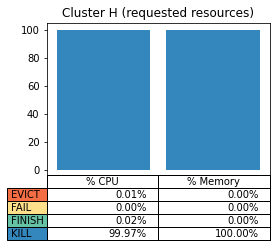

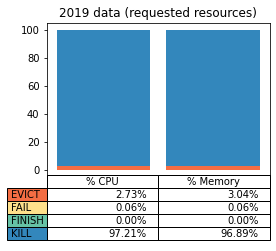

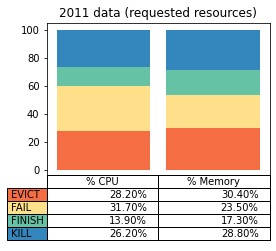

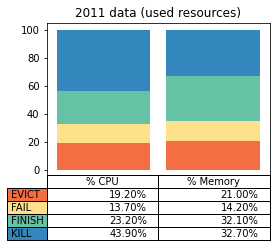

In [157]:

dft = None
for cluster in "abcd":
    df = pd.read_csv(glob.glob(DIR + cluster + "_actual/part-*")[0], header=None,
                    names=["term", "cpu", "ram"])
    plot_df(df, cluster, "used")
    if dft is None:
        dft = df
    else:
        dft = dft.append(df)

dft = dft.groupby("term").sum().reset_index()
plot_df(dft, "all", "used")

dft = None
for cluster in "abcdefgh":
    data = None
    with open(DIR + cluster + "_res_micros_requested.json", "r") as f:
        data = json.loads(f.read())
    dfd = {'term': [], 'cpu': [], 'ram': []}
    for term in [4,5,6,7]:
        dfd['term'].append(term)
        dfd['cpu'].append(float(data["cpu-" + ("None" if term == -1 else str(term))]))
        dfd['ram'].append(float(data["ram-" + ("None" if term == -1 else str(term))]))
    df = pd.DataFrame(dfd, columns=['term', 'cpu', 'ram'])
    if dft is None:
        dft = df
    else:
        dft = dft.append(df)
    plot_df(df, cluster, "requested")
    
dft = dft.groupby("term").sum().reset_index()
plot_df(dft, "all", "requested")

dfr2011 = {'term': [4,5,6,7], 'cpu': [28.2, 31.7, 13.9, 26.2], 'ram': [30.4,23.5, 17.3, 28.8]}
dfr2011 = pd.DataFrame(dfr2011, columns=dfr2011.keys())
dfa2011 = {'term': [4,5,6,7],'cpu': [19.2, 13.7, 23.2, 43.9], 'ram': [21.0,14.2,32.1,32.7]}
dfa2011 = pd.DataFrame(dfa2011, columns=dfa2011.keys())

plot_df(dfr2011, "2011", "requested")
plot_df(dfa2011, "2011", "used")